In [1]:
import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import evaluate
from tqdm import tqdm

/workspace/ml_approx/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("white")
sns.set_palette("husl", 10)
sns.set_context("paper")

In [3]:
cs = np.linspace(0, 1, 769)

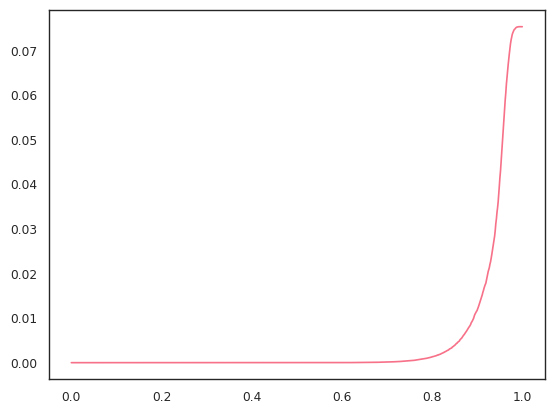

In [12]:
plt.plot(cs, np.load("data/distilbert_ag_news/aA_ab_l2_quantize.npy"))

In [3]:
dataset = load_dataset("ag_news")
dataset = dataset.rename_column("label", "labels")

model_name = "textattack/distilbert-base-uncased-ag-news"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name).cuda()

def preprocess(example):
    return tokenizer(example["text"], truncation=True, padding="max_length", max_length=256)

encoded = dataset["test"].map(preprocess, batched=True)
encoded.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

test_loader = DataLoader(encoded, batch_size=64)

Map: 100%|██████████| 7600/7600 [00:01<00:00, 6710.88 examples/s]


In [4]:
weight = model.pre_classifier.weight.data.cpu().numpy()
weight

array([[ 1.0534561e-02, -7.2031449e-05, -2.2871409e-02, ...,
         1.0889420e-02,  3.3197316e-04,  7.0067388e-03],
       [-9.2872456e-03, -1.4960178e-02,  7.0237159e-03, ...,
         4.2384610e-02,  2.7817275e-02, -1.2560167e-02],
       [ 3.0747654e-03, -1.6427493e-02,  4.9802411e-02, ...,
        -3.9113984e-02,  9.4633456e-03, -2.4966795e-02],
       ...,
       [ 1.4107680e-03,  6.9884933e-03,  3.7035737e-02, ...,
         4.6152207e-03,  2.3223845e-02,  1.1142994e-02],
       [ 3.5105053e-02, -1.9424977e-02,  1.2274773e-02, ...,
        -1.0470627e-02,  3.2378554e-02, -2.8432989e-03],
       [ 9.1076660e-04, -6.6304230e-03, -1.0209803e-02, ...,
         5.7605898e-04,  2.6611900e-02,  1.3482934e-02]],
      shape=(768, 768), dtype=float32)

In [10]:
# l2 error

cs = np.concat((
    np.arange(0, 128, 8),
    np.arange(128, 192, 4),
    np.arange(192, 224, 2),
    np.arange(224, 257, 1),
)) / 256

In [80]:
# actual memory save
def spectral_save(A, c):
    m, n = A.shape
    rank = math.floor((1 - c) * min(m, n))
    return 1 - rank * (m + n - rank) / (m * n)

def sparse_save(A, c):
    m, n = A.shape
    num_entries = math.floor((1 - c) * m * n)
    csr_cnt = 2 * num_entries + min(m, n) + 1
    return max(0, 1 - csr_cnt / (m * n))

def quant_save(A, c):
    return math.floor(c * 32) / 32

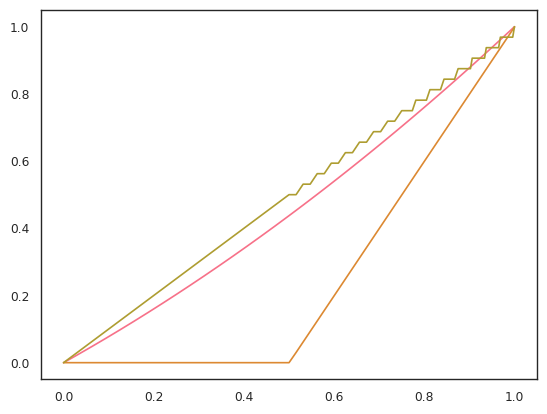

In [85]:
A = np.random.randn(256, 1024)
plt.plot(cs, [spectral_save(A, c) for c in cs])
plt.plot(cs, [sparse_save(A, c) for c in cs])
plt.plot(cs, [quant_save(A, c) for c in cs])

In [4]:
methods = [
    "exact_sparse",
    "weighted_rand_sparse_0",
    "weighted_rand_sparse_1",
    "weighted_rand_sparse_2",
    "low_rank",
    "quantize",
    "rand_svd_0",
    # "rand_svd_1",
    "rand_svd_2",
]

In [5]:
l2_dists = {}
accs = {}

Text(0, 0.5, 'Accuracy')

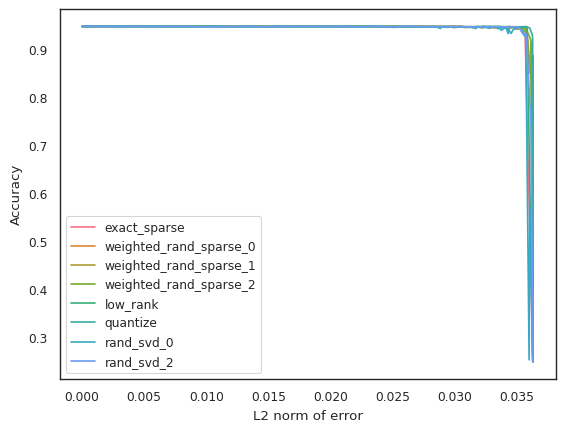

In [ ]:
# experiment = "alexnet_cifar10"
experiment = "distilbert_ag_news"

for method in methods:
    l2_dists[method] = np.load(f"/workspace/ml_approx/data/{experiment}/aA_ab_l2_{method}.npy")
    accs[method] = np.load(f"/workspace/ml_approx/data/{experiment}/aA_ab_acc_{method}.npy")
    sns.lineplot(x=l2_dists[method], y=accs[method], label=method)
plt.xlabel("L2 norm of error")
plt.ylabel("Accuracy")


quantize


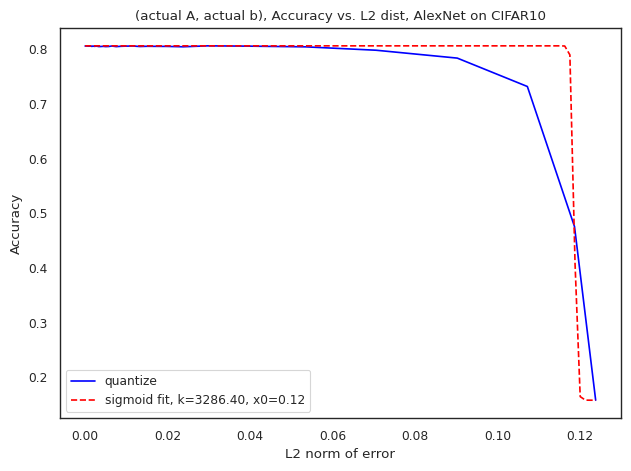

In [70]:
# fit sigmoid
method = methods[5]
print(method)

def fit_sigmoid(method):
    x = l2_dists[method]
    y = accs[method]
    mn = y.min()
    mx = y.max()

    def sigmoid(x, k, x0):
        return (mx - mn) / (1 + np.exp(k * (x - x0))) + mn

    from scipy.optimize import curve_fit
    params, _ = curve_fit(sigmoid, x, y)
    # return params
    sns.lineplot(x=x, y=y, label=method, linestyle="-", color="blue")
    x_fit = np.linspace(x.min(), x.max(), 100)
    sns.lineplot(x=x_fit, y=sigmoid(x_fit, *params), label=f"sigmoid fit, k={params[0]:.2f}, x0={params[1]:.2f}", linestyle="--", color="red")

fit_sigmoid(method)
plt.title(f'(actual A, actual b), Accuracy vs. L2 dist, AlexNet on CIFAR10')
plt.xlabel("L2 norm of error")
plt.ylabel("Accuracy")
plt.tight_layout()
plt.savefig(f"/workspace/ml_approx/diagrams/alexnet_cifar10/aA_ab_l2_vs_acc_sigmoid_{method}.png", dpi=300)

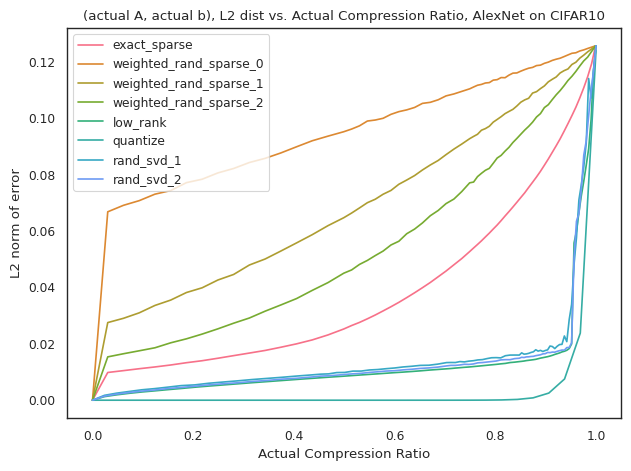

In [95]:
A = np.random.randn(256, 1024)
for method in methods:
    actual_cs = []
    if method in ("exact_sparse", "weighted_rand_sparse_0", "weighted_rand_sparse_1", "weighted_rand_sparse_2"):
        actual_cs = [sparse_save(A, c) for c in cs]
    elif method in ("low_rank", "rand_svd_0", "rand_svd_1", "rand_svd_2"):
        actual_cs = [spectral_save(A, c) for c in cs]
    elif method == "quantize":
        actual_cs = [quant_save(A, c) for c in cs]
    else:
        raise ValueError(f"Unknown method: {method}")
    _, unique_indices = np.unique(actual_cs, return_index=True)
    x_clean = np.array(actual_cs)[unique_indices]
    y_clean = l2_dists[method][unique_indices]
    sns.lineplot(x=x_clean, y=y_clean, label=method)

plt.title(f'(actual A, actual b), L2 dist vs. Actual Compression Ratio, AlexNet on CIFAR10')
plt.xlabel("Actual Compression Ratio")
plt.ylabel("L2 norm of error")
plt.tight_layout()
plt.savefig(f"/workspace/ml_approx/diagrams/alexnet_cifar10/aA_ab_l2_vs_actual_cs.png", dpi=300)
    

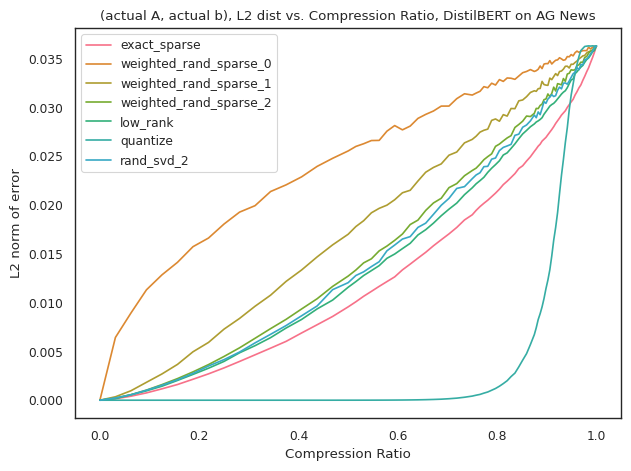

In [ ]:
for method in methods:
    l2_dists[method] = np.load(f"/workspace/ml_approx/data/distilbert_ag_news/aA_ab_l2_{method}.npy")
    sns.lineplot(x=cs, y=l2_dists[method], label=method)

plt.xlabel("Compression Ratio")
plt.ylabel("L2 norm of error")
plt.title(f'(actual A, actual b), L2 dist vs. Compression Ratio, DistilBERT on AG News')
plt.tight_layout()
plt.savefig(f"/workspace/ml_approx/diagrams/distilbert_ag_news/aA_ab_l2.png", dpi=300)

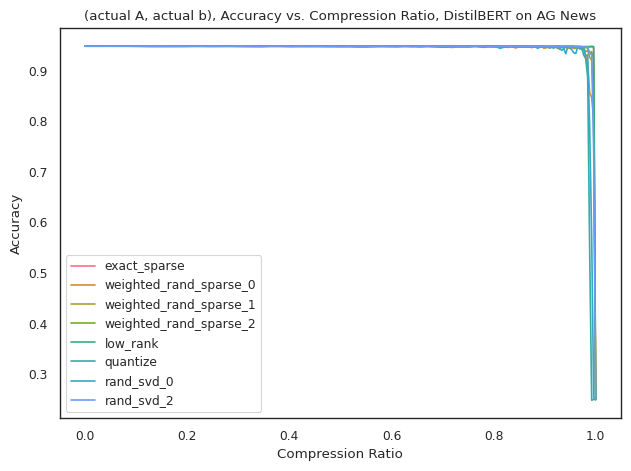

In [11]:
for method in methods:
    sns.lineplot(x=cs, y=accs[method], label=method)

plt.xlabel("Compression Ratio")
plt.ylabel("Accuracy")
plt.title(f'(actual A, actual b), Accuracy vs. Compression Ratio, DistilBERT on AG News')
plt.tight_layout()
plt.savefig(f"/workspace/ml_approx/diagrams/distilbert_ag_news/aA_ab_acc.png", dpi=300)